In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from astropy.time import Time
from astropy.timeseries import LombScargle
import exoplanet as xo
import celerite
from celerite import terms
from scipy.optimize import minimize

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

Start w/ the data from V1, AAVSO light curve up thru early 2020, plus new STEREO data...

In [3]:
file = 'aavsodata_5f20eb1154bf8.txt'
df = pd.read_csv(file)
# df

/Users/james/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,15,22,23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.columns

Index(['JD', 'Magnitude', 'Uncertainty', 'HQuncertainty', 'Band',
       'Observer Code', 'Comment Code(s)', 'Comp Star 1', 'Comp Star 2',
       'Charts', 'Comments', 'Transfomed', 'Airmass', 'Validation Flag',
       'Cmag', 'Kmag', 'HJD', 'Star Name', 'Observer Affiliation',
       'Measurement Method', 'Grouping Method', 'ADS Reference', 'Digitizer',
       'Credit'],
      dtype='object')

In [11]:
vok = np.where((df['Uncertainty'] < 0.1) &          # select only "good" data
               (df['Band'] == 'V') &                # in V band
               (df['JD'] > (2459059.6638 - 41*365)) # within last ~40yrs
              )[0]

np.size(vok) # how many data points do we have?

1579

In [12]:
# manually add data from the STEREO ATel
new_dates = Time(['2020-06-24', '2020-7-13', '2020-07-20'], format='isot', scale='utc')
new_mags = [0.66, 0.76, 0.80]
new_errs = [0.015, 0.015, 0.015]

 now add new data from AAVSO, manually pulled from the "WebObs" page
   https://aavso.org/apps/webobs/results/?star=BETELGEUSE

In [13]:
df2 = pd.read_table('new_AAVSO_data.txt', delimiter='\t')
df2.columns

Index(['JD', 'Calendar Date', 'Magnitude', 'Error', 'Filter', 'Observer'], dtype='object')

In [14]:
vok2 = np.where((df2['Error'] < 0.1))[0]
sum(df2['Error'] < 0.1) # a few good observations

10

In [18]:
time = Time(df['JD'].values[vok], format='jd')
time2 = Time(df2['JD'].values[vok2], format='jd')

In [19]:
XX = time.to_value('decimalyear')
YY = df['Magnitude'][vok].astype('float').values
EE = df['Uncertainty'][vok].values

XX = np.append(XX, new_dates.to_value('decimalyear'))
YY = np.append(YY, new_mags)
EE = np.append(EE, new_errs)

ss = np.argsort(XX)
XX = XX[ss]
YY = YY[ss]
EE = EE[ss]

In [20]:
XX2 = time2.to_value('decimalyear')
YY2 = df2['Magnitude'][vok2].astype('float').values
EE2 = df2['Error'][vok2].values


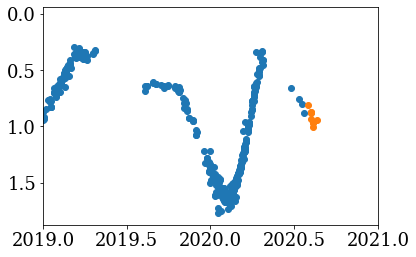

In [25]:
# let's compare the OLD vs NEW data I've got
plt.scatter(XX, YY)
plt.scatter(XX2, YY2)
plt.xlim(2019,2021)

plt.gca().invert_yaxis()
# OK! still going down!

In [8]:
# df_out = pd.DataFrame(data={'time':XX, 'Vmag':YY, 'Verr':EE})
# df_out.to_csv('AlphaOri_AAVSO_ATEL.csv')

In [26]:
import pymc3 as pm
import theano.tensor as tt

KNOWNPERIOD = 420./365. # rough guess from literature search...

with pm.Model() as model:

    # The mean flux of the time series (V mag in this case)
    mean = pm.Normal("mean", mu=np.mean(YY), sd=2.)

    # A jitter term describing excess white noise
    logs2 = pm.Normal("logs2", mu=2 * np.log(np.mean(EE)), sd=2.0)

    # A term to describe the non-periodic variability
    logSw4 = pm.Normal("logSw4", mu=np.log(np.var(YY)), sd=5.0)
    logw0 = pm.Normal("logw0", mu=np.log(2 * np.pi / 10), sd=5.0)

    # The parameters of the RotationTerm kernel
    logamp = pm.Normal("logamp", mu=np.log(np.var(YY)), sd=5.0)
#     BoundedNormal = pm.Bound(pm.Normal, lower=0.0, upper=np.log(50))
#     logperiod = BoundedNormal("logperiod", mu=np.log(KNOWNPERIOD), sd=5.0)
    logperiod = pm.Uniform("logperiod", lower=-1, upper=1)
    logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
    logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
    mix = xo.distributions.UnitUniform("mix")

    # Track the period as a deterministic
    period = pm.Deterministic("period", tt.exp(logperiod))

    # Set up the Gaussian Process model
    kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1 / np.sqrt(2))
    kernel += xo.gp.terms.RotationTerm(
        log_amp=logamp, period=period, log_Q0=logQ0, log_deltaQ=logdeltaQ, mix=mix
    )
    gp = xo.gp.GP(kernel, XX, EE ** 2 + tt.exp(logs2), mean=mean)

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=YY)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict())

    # Optimize to find the maximum a posteriori parameters
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
46it [00:22,  2.07it/s, logp=2.661947e+03] 
message: Optimization terminated successfully.
logp: 883.3357865746876 -> 2661.947461050823


In [27]:
map_soln

{'mean': array(0.56356459),
 'logs2': array(-6.8714317),
 'logSw4': array(-1.72790707),
 'logw0': array(0.69677994),
 'logamp': array(-4.17754917),
 'logperiod_interval__': array(0.13542534),
 'logQ0': array(1.03346792),
 'logdeltaQ': array(3.2546865),
 'mix_logodds__': array(0.33466958),
 'logperiod': array(0.06760937),
 'mix': array(0.58289512),
 'period': array(1.06994728),
 'pred': array([0.01961484, 0.03057496, 0.07600814, ..., 0.22009772, 0.26271984,
        0.27445073])}

In [28]:
xnew = np.linspace(XX.min(), 2022, 1500)

with model:
    mu1, var1 = xo.eval_in_model(gp.predict(xnew, return_var=True), map_soln)

Text(0, 0.5, 'V mag')

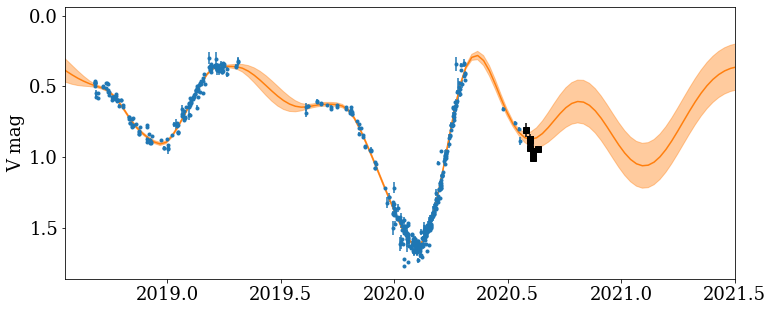

In [33]:
plt.figure(figsize=(12,5))
plt.errorbar(XX,YY, yerr=EE, linestyle='none', marker='.')

plt.errorbar(XX2, YY2, yerr=EE2, linestyle='none', marker='s', c='k')


# plt.plot(XX, map_soln["pred"] + map_soln['mean'], c='C1')
plt.plot(xnew, mu1+map_soln['mean'], c='C1')
plt.fill_between(xnew, mu1-np.sqrt(var1)+map_soln['mean'], 
                 mu1+np.sqrt(var1)+map_soln['mean'], 
                 alpha=0.4, color='C1')

plt.gca().invert_yaxis()
plt.xlim(2018.55, 2021.5)
plt.ylabel('V mag')

In [36]:
# now fold together new data and make updated prediction again...

print(len(XX))
XX = np.append(XX, XX2)
YY = np.append(YY, YY2)
EE = np.append(EE, EE2)

ss = np.argsort(XX) # sort again, juuuuust incase
XX = XX[ss]
YY = YY[ss]
EE = EE[ss]

print(len(XX))

1582
1592


In [37]:
with pm.Model() as model2:

    # The mean flux of the time series (V mag in this case)
    mean = pm.Normal("mean", mu=np.mean(YY), sd=2.)

    # A jitter term describing excess white noise
    logs2 = pm.Normal("logs2", mu=2 * np.log(np.mean(EE)), sd=2.0)

    # A term to describe the non-periodic variability
    logSw4 = pm.Normal("logSw4", mu=np.log(np.var(YY)), sd=5.0)
    logw0 = pm.Normal("logw0", mu=np.log(2 * np.pi / 10), sd=5.0)

    # The parameters of the RotationTerm kernel
    logamp = pm.Normal("logamp", mu=np.log(np.var(YY)), sd=5.0)
#     BoundedNormal = pm.Bound(pm.Normal, lower=0.0, upper=np.log(50))
#     logperiod = BoundedNormal("logperiod", mu=np.log(KNOWNPERIOD), sd=5.0)
    logperiod = pm.Uniform("logperiod", lower=-1, upper=1)
    logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
    logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
    mix = xo.distributions.UnitUniform("mix")

    # Track the period as a deterministic
    period = pm.Deterministic("period", tt.exp(logperiod))

    # Set up the Gaussian Process model
    kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1 / np.sqrt(2))
    kernel += xo.gp.terms.RotationTerm(
        log_amp=logamp, period=period, log_Q0=logQ0, log_deltaQ=logdeltaQ, mix=mix
    )
    gp = xo.gp.GP(kernel, XX, EE ** 2 + tt.exp(logs2), mean=mean)

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=YY)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict())

    # Optimize to find the maximum a posteriori parameters
    map_soln2 = xo.optimize(start=model2.test_point)

optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
60it [00:01, 34.44it/s, logp=2.660741e+03] 
message: Desired error not necessarily achieved due to precision loss.
logp: 921.2599840441791 -> 2660.748822041799


In [39]:
with model2:
    mu2, var2 = xo.eval_in_model(gp.predict(xnew, return_var=True), map_soln2)

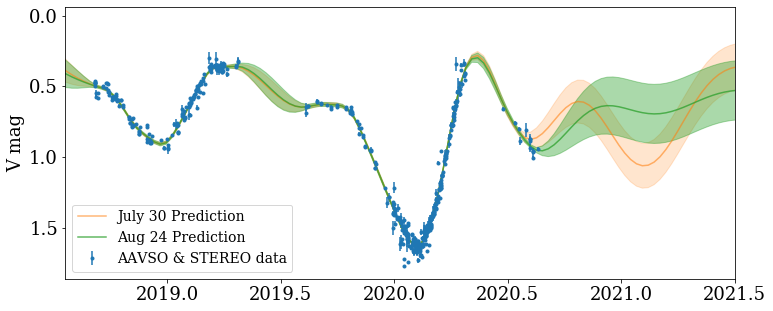

In [51]:
plt.figure(figsize=(12,5))
plt.errorbar(XX,YY, yerr=EE, linestyle='none', marker='.', label='AAVSO & STEREO data')

# plt.errorbar(XX2, YY2, yerr=EE2, linestyle='none', marker='s', c='k')


plt.plot(xnew, mu1+map_soln['mean'], c='C1', alpha=0.57, label='July 30 Prediction')
plt.fill_between(xnew, mu1-np.sqrt(var1)+map_soln['mean'], 
                 mu1+np.sqrt(var1)+map_soln['mean'], 
                 alpha=0.2, color='C1')

plt.plot(xnew, mu2+map_soln2['mean'], c='C2', alpha=0.75, label='Aug 24 Prediction')
plt.fill_between(xnew, mu2-np.sqrt(var2)+map_soln2['mean'], 
                 mu2+np.sqrt(var2)+map_soln2['mean'], 
                 alpha=0.4, color='C2')


plt.gca().invert_yaxis()
plt.xlim(2018.55, 2021.5)
plt.ylabel('V mag')
plt.legend(fontsize=14)
plt.savefig('gp_lightcurve.png', bbox_inches='tight', pad_inches=0.25, dpi=100)


In [21]:
with model:
    trace = pm.sample(tune=500, draws=500, start=map_soln, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [01:13<00:00, 27.10draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


Text(0, 0.5, 'V mag')

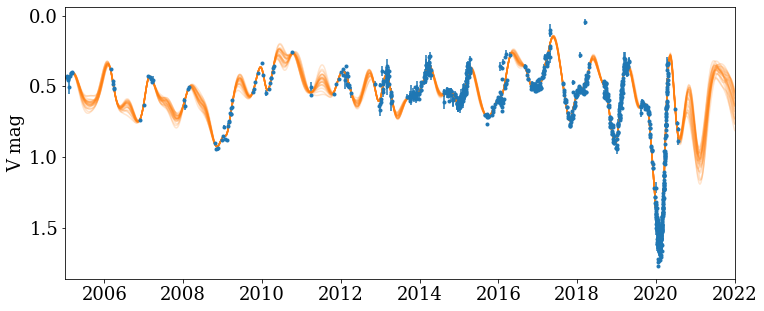

In [36]:
plt.figure(figsize=(12,5))
plt.errorbar(XX,YY, yerr=EE, linestyle='none', marker='.')

with model:
    for k in range(25):
        mu_k = xo.eval_in_model(gp.predict(xnew, return_var=False), trace[k])
        plt.plot(xnew, mu_k + trace[k]['mean'], c='C1', alpha=0.2)
    
plt.gca().invert_yaxis()
plt.xlim(2005,2022)
plt.ylabel('V mag')

In [25]:
with model:
    mu, var = xo.eval_in_model(gp.predict(xnew, return_var=True), trace[1])

Text(0, 0.5, 'V mag')

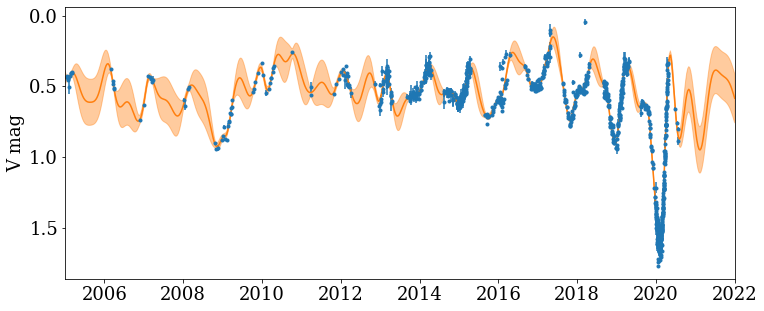

In [26]:
plt.figure(figsize=(12, 5))
plt.errorbar(XX,YY, yerr=EE, linestyle='none', marker='.')

plt.plot(xnew, mu+trace[1]['mean'], c='C1')
plt.fill_between(xnew, mu-np.sqrt(var)+trace[1]['mean'], 
                 mu+np.sqrt(var)+trace[1]['mean'], 
                 alpha=0.4, color='C1')

plt.gca().invert_yaxis()
plt.xlim(2005,2022)
plt.ylabel('V mag')

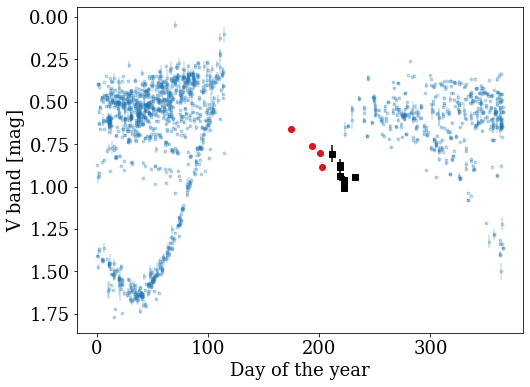

In [35]:
# just how special is that new data?
plt.figure(figsize=(8,6))
plt.errorbar((XX % 1)*365.,YY, yerr=EE, linestyle='none', marker='.', alpha=0.24,c='C0')
plt.errorbar((XX2 % 1)*365.,YY2, yerr=EE2, linestyle='none', marker='s', c='k')


plt.scatter((XX[-4:] % 1)*365., YY[-4:], c='r')
plt.xlabel('Day of the year')
plt.ylabel('V band [mag]')
plt.gca().invert_yaxis()